<a href="https://www.kaggle.com/code/abhijitdarekar001/u2net-model-image-segmentation?scriptVersionId=152900683" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Implementation of U2Net Model for single shot image segmentation

## Importing Libraries ⬇️

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from PIL import Image

import tensorflow as tf
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split

import os
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
!pip install -q visualkeras
import visualkeras


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class CFG:
    path='/kaggle/input/flood-area-segmentation/'
    metaFile=path+'metadata.csv'
    imageDir = path+'Image'
    MaskDir = path+'Mask'
    imageSize = 256

In [3]:
meta = pd.read_csv(CFG.metaFile)
meta.head()

,Image,Mask
0,0.jpg,0.png
1,1.jpg,1.png
2,2.jpg,2.png
3,3.jpg,3.png
4,4.jpg,4.png


In [4]:
images = os.listdir(CFG.imageDir)
masks = os.listdir(CFG.MaskDir)

## Image Loading and Processing

In [5]:
X_train, X_test,y_train,y_test  = train_test_split(sorted(images),sorted(masks),test_size=0.2,random_state=23)

In [6]:
def load_img(path):
    try:
        img=Image.open(path)
        return img
    except Exception as e:
        print("Caught Exception :",e)
        return None

In [7]:
def load_data(paths,image_size=256, gray= False):
    data=[]
    try:
        for image in tqdm(paths):
            if image.split("/")[-1] in ['3048.jpg','0.jpg',"2.jpg","3048.png","0.png","2.png"]:
                continue
            else:
                img = load_img(image)
                if gray:
                    img = img.convert("L")
                img = img.resize((image_size, image_size))
                img_array = np.array(img)
                if gray:
                    img_array = img_array.reshape((image_size, image_size, 1))
            data.append(img_array)
        return np.array(data)
    except Exception as e:
        print("Caught Expection : ",e)
        
        

In [8]:
X_train_images = load_data([CFG.imageDir+ '/' +x for x in X_train])

100%|██████████| 232/232 [00:08<00:00, 27.62it/s]


In [9]:
X_test_images = load_data([CFG.imageDir+ '/' +x for x in X_test])

100%|██████████| 58/58 [00:02<00:00, 28.31it/s]


In [10]:
y_train_images = load_data(paths=[CFG.MaskDir+ '/' +x for x in y_train],gray=True)/255.0

100%|██████████| 232/232 [00:03<00:00, 58.78it/s]


In [11]:
y_test_images = load_data(paths=[CFG.MaskDir+ '/' +x for x in y_test],gray=True)/255.0

100%|██████████| 58/58 [00:00<00:00, 61.31it/s]


In [12]:
X_train_images.shape, y_train_images.shape , X_test_images.shape, y_test_images.shape

((229, 256, 256, 3), (229, 256, 256, 1), (58, 256, 256, 3), (58, 256, 256, 1))

In [13]:
def plot(image,mask,predicted_mask=np.array([])):
    axis=2
    plt.figure(figsize=(10,3))
    if predicted_mask.any():
        plt.suptitle('Plotting Predictions')
        axis=3
        plt.subplot(1,axis,3)
        plt.title("Predicted Mask")
        plt.imshow(predicted_mask)
    
    plt.subplot(1,axis,1)
    plt.title("Orignal Image")
    plt.imshow(image)
    
    plt.subplot(1,axis,2)
    plt.title("Mask Image")
    plt.imshow(mask)
    
    plt.tight_layout()

#### Plotting initial Images

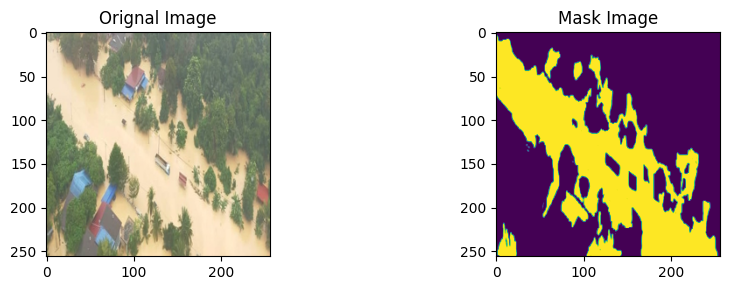

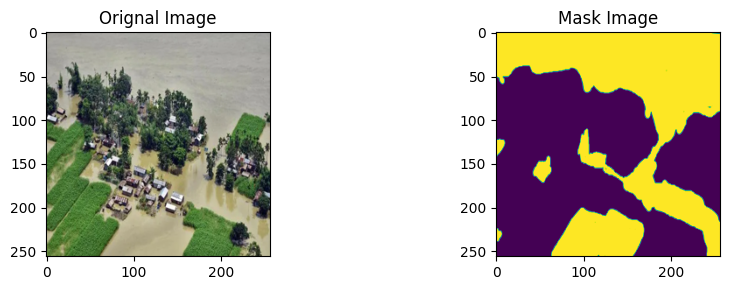

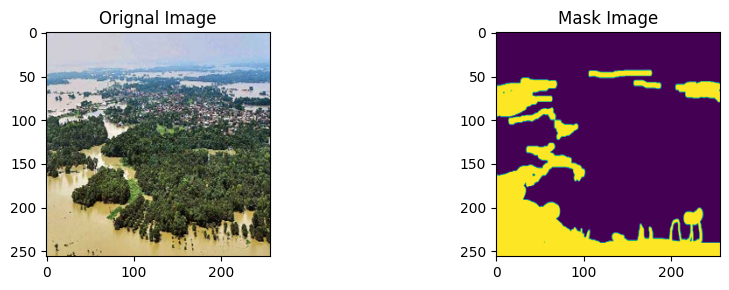

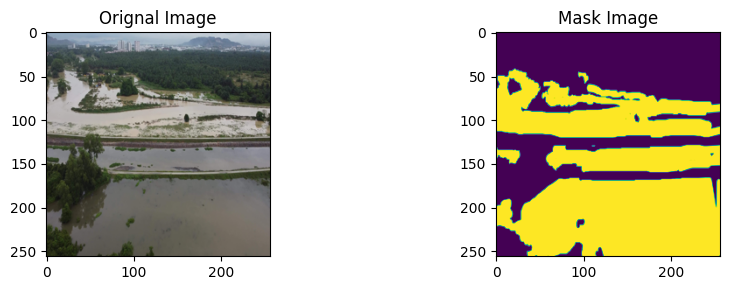

In [14]:
for i in range(4):
    plot(X_train_images[i],y_train_images[i])

### Model Construction ⚒️🏗️

In [15]:
def conv_block(shape, out_ch, rate=1):
    x = tf.keras.layers.Conv2D(out_ch, 3, padding="same", dilation_rate=1)(shape)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


In [16]:
def RSU_L(shape, out_ch, M_ch, num_layers, rate=2):
    x = conv_block(shape, out_ch)
    inp_ch = x

    skip_features = []
    x = conv_block(x, M_ch)
    skip_features.append(x)

    for i in range(num_layers-2):
        x = tf.keras.layers.MaxPool2D((2, 2))(x)
        x = conv_block(x, M_ch)
        skip_features.append(x)
        
    x = conv_block(x, M_ch, rate=rate)
    skip_features.reverse()
    x = tf.keras.layers.Concatenate()([x, skip_features[0]])
    x = conv_block(x, M_ch)

    for i in range(num_layers-3):
        x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
        x = tf.keras.layers.Concatenate()([x, skip_features[i+1]])
        x = conv_block(x, M_ch)

    x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = tf.keras.layers.Concatenate()([x, skip_features[-1]])
    x = conv_block(x, out_ch)

    x = tf.keras.layers.Add()([x, inp_ch])
    return x


In [17]:

def RESU_4F(shape, out_ch, M_ch):
    x0 = conv_block(shape, out_ch, rate=1)

    x1 = conv_block(x0, M_ch, rate=1)
    x2 = conv_block(x1, M_ch, rate=2)
    x3 = conv_block(x2, M_ch, rate=4)

    x4 = conv_block(x3, M_ch, rate=8)

    x = tf.keras.layers.Concatenate()([x4, x3])
    x = conv_block(x, M_ch, rate=4)

    x = tf.keras.layers.Concatenate()([x, x2])
    x = conv_block(x, M_ch, rate=2)

    x = tf.keras.layers.Concatenate()([x, x1])
    x = conv_block(x, out_ch, rate=1)

    x = tf.keras.layers.Add()([x, x0])
    return x
    

In [18]:

def u2net(shape, out_ch, M_ch, num_classes=1):
    inputs = tf.keras.layers.Input(shape)

    e1 = RSU_L(inputs, out_ch[0], M_ch[0], 7)
    p1 = tf.keras.layers.MaxPool2D((2, 2))(e1)

    e2 = RSU_L(p1, out_ch[1], M_ch[1], 6)
    p2 = tf.keras.layers.MaxPool2D((2, 2))(e2)

    e3 = RSU_L(p2, out_ch[2], M_ch[2], 5)
    p3 = tf.keras.layers.MaxPool2D((2, 2))(e3)

    e4 = RSU_L(p3, out_ch[3], M_ch[3], 4)
    p4 = tf.keras.layers.MaxPool2D((2, 2))(e4)
    
    e5 = RESU_4F(p4, out_ch[4], M_ch[4])
    p5 = tf.keras.layers.MaxPool2D((2, 2))(e5)

    b1 = RESU_4F(p5, out_ch[5], M_ch[5])
    b2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(b1)

    d1 = tf.keras.layers.Concatenate()([b2, e5])
    d1 = RESU_4F(d1, out_ch[6], M_ch[6])
    u1 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d1)

    d2 = tf.keras.layers.Concatenate()([u1, e4])
    d2 = RSU_L(d2, out_ch[7], M_ch[7], 4)
    u2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d2)

    d3 = tf.keras.layers.Concatenate()([u2, e3])
    d3 = RSU_L(d3, out_ch[8], M_ch[8], 5)
    u3 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d3)
    
    d4 = tf.keras.layers.Concatenate()([u3, e2])
    d4 = RSU_L(d4, out_ch[9], M_ch[9], 6)
    u4 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d4)

    d5 = tf.keras.layers.Concatenate()([u4, e1])
    d5 = RSU_L(d5, out_ch[10], M_ch[10], 7)

    
    y1 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d5)

    y2 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d4)
    y2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(y2)

    y3 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d3)
    y3 = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(y3)

    y4 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d2)
    y4 = tf.keras.layers.UpSampling2D(size=(8, 8), interpolation="bilinear")(y4)

    y5 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d1)
    y5 = tf.keras.layers.UpSampling2D(size=(16, 16), interpolation="bilinear")(y5)
    
    y6 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(b1)
    y6 = tf.keras.layers.UpSampling2D(size=(32, 32), interpolation="bilinear")(y6)

    y0 = tf.keras.layers.Concatenate()([y1, y2, y3, y4, y5, y6])
    y0 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(y0)

    y0 = tf.keras.layers.Activation("sigmoid")(y0)
    y1 = tf.keras.layers.Activation("sigmoid")(y1)
    y2 = tf.keras.layers.Activation("sigmoid")(y2)
    y3 = tf.keras.layers.Activation("sigmoid")(y3)
    y4 = tf.keras.layers.Activation("sigmoid")(y4)
    y5 = tf.keras.layers.Activation("sigmoid")(y5)
    y6 = tf.keras.layers.Activation("sigmoid")(y6)

    model = tf.keras.models.Model(inputs, outputs=y0, name="U2-Net")
    return model

In [19]:
def build_u2net(input_shape, num_classes=1):
    out_ch = [64, 128, 256, 512, 512, 512, 512, 256, 128, 64, 64]
    M_ch = [32, 32, 64, 128, 256, 256, 256, 128, 64, 32, 16]
    model = u2net(input_shape, out_ch, M_ch, num_classes=num_classes)
    return model
u2net_model = build_u2net((CFG.imageSize, CFG.imageSize, 3))

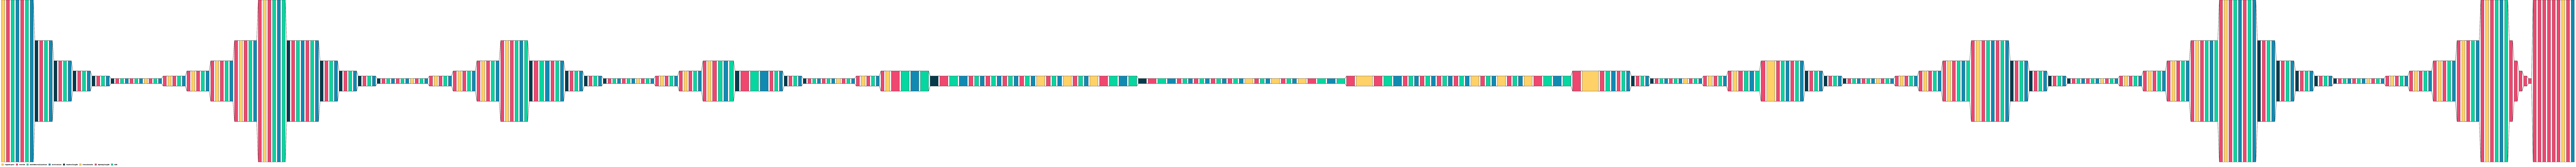

In [20]:
visualkeras.layered_view(u2net_model,to_file='output.png', legend=True ,  draw_volume=False, spacing =10)

In [21]:
u2net_model.summary(expand_nested=True)

Model: "U2-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][

#### Training Parameters

In [22]:
def bce_loss(y_true,y_pred):
    y_true=K.cast(y_true,'float32')
    y_pred=K.cast(y_pred,'float32')
    return tf.keras.losses.binary_crossentropy(y_true,y_pred)
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    
    intersection = K.sum(y_true_f * y_pred_f)
    dice_coef_v = (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)
    return dice_coef_v
def dice_loss(y_true, y_pred):
    dice_loss_v = 1 - dice_coef(y_true, y_pred)
    return dice_loss_v
def bce_dice_loss(y_true, y_pred):
    bce_dice_loss_v = bce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)
    return bce_dice_loss_v

In [23]:
loss_init = bce_dice_loss
metrics = [dice_coef]

In [24]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
u2net_model.compile(optimizer=opt, loss=loss_init, metrics=metrics)

In [25]:
def get_callbacks():
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    checkpoint = tf.keras.callbacks.ModelCheckpoint('flood.hdf5',verbose=1, save_best_only= True)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    return [reduce_lr, checkpoint, early_stop]

In [26]:
history = u2net_model.fit(X_train_images, y_train_images,validation_data=(X_test_images,y_test_images), validation_split = 0.2,batch_size = 8, epochs = 50, callbacks=get_callbacks())

Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 1.0720 - dice_coef: 0.6671
Epoch 1: val_loss improved from inf to 87215341568.00000, saving model to flood.hdf5
29/29 [==============================] - 115s 749ms/step - loss: 1.0720 - dice_coef: 0.6671 - val_loss: 87215341568.0000 - val_dice_coef: 0.0207 - lr: 0.0010
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 0.6169 - dice_coef: 0.7579
Epoch 2: val_loss improved from 87215341568.00000 to 1960640.37500, saving model to flood.hdf5
29/29 [==============================] - 11s 388ms/step - loss: 0.6169 - dice_coef: 0.7579 - val_loss: 1960640.3750 - val_dice_coef: 0.0423 - lr: 0.0010
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 0.5983 - dice_coef: 0.7688
Epoch 3: val_loss improved from 1960640.37500 to 391.67807, saving model to flood.hdf5
29/29 [==============================] - 11s 386ms/step - loss: 0.5983 - dice_coef: 0.7688 - val_loss: 391.6781 - val_dice_coef: 0.0509 -

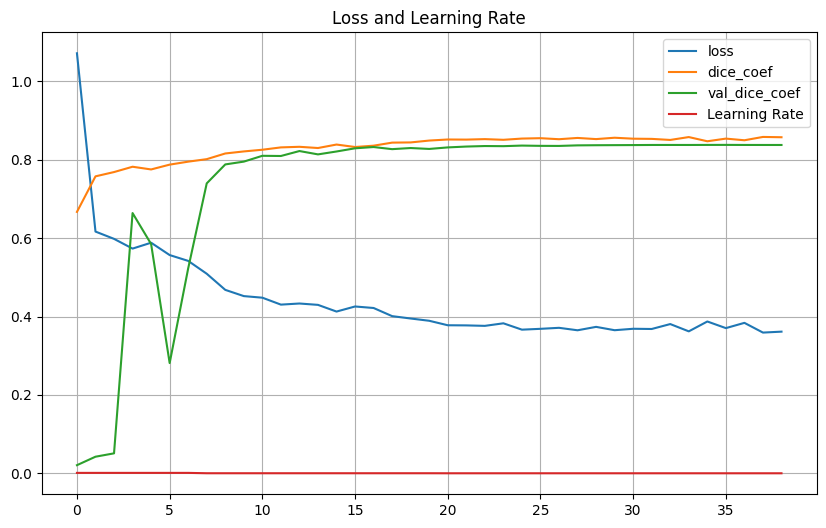

In [27]:
plt.figure(figsize=(10,6))
plt.title("Loss and Learning Rate")
plt.plot(history.history['loss'])
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.plot(history.history['lr'])
plt.grid()
plt.legend(['loss','dice_coef','val_dice_coef','Learning Rate'])
plt.show()

## Prediction

1/1 [==============================] - 0s 31ms/step


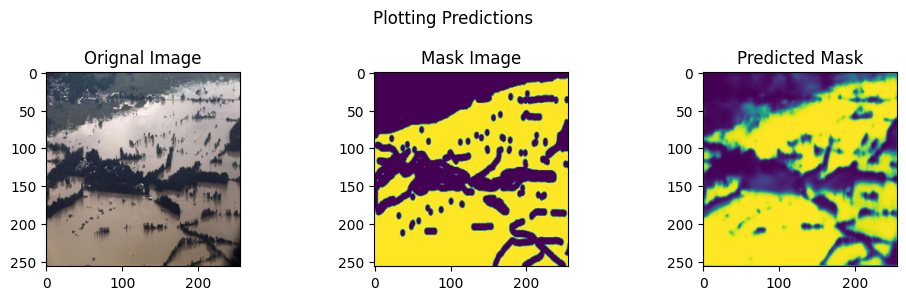

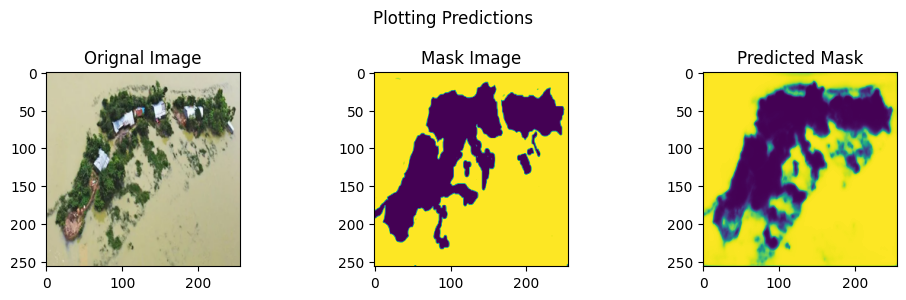

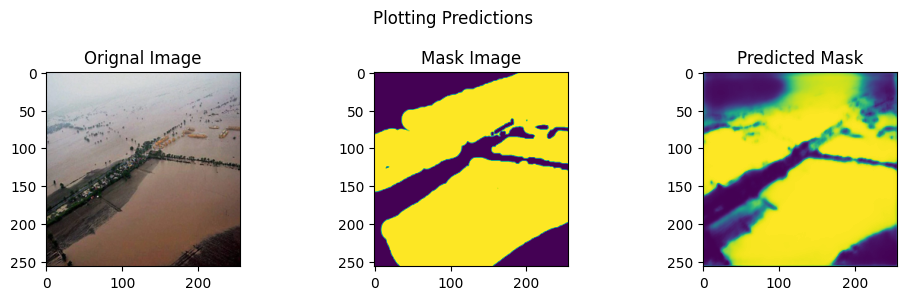

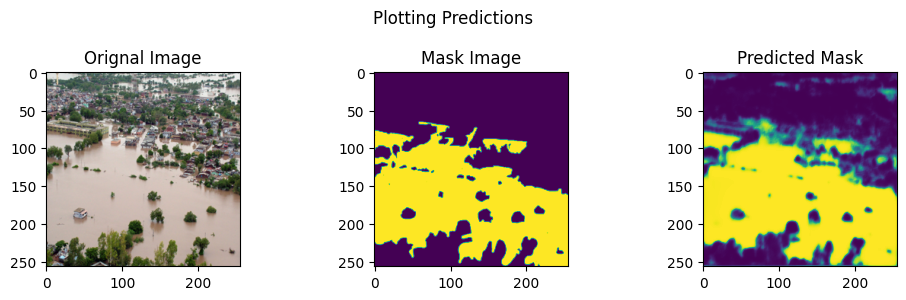

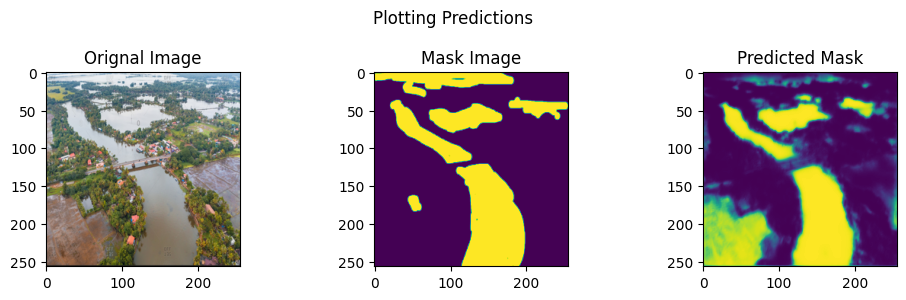

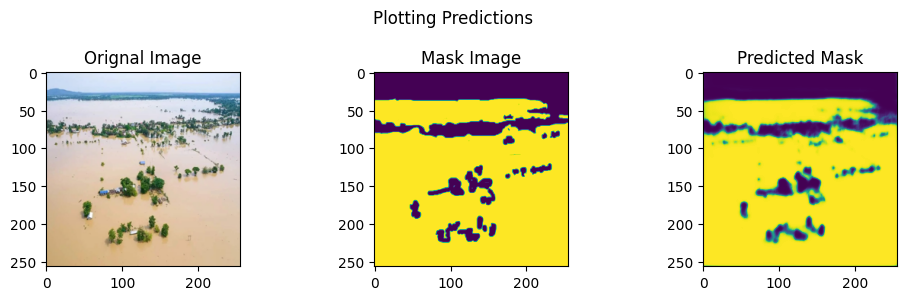

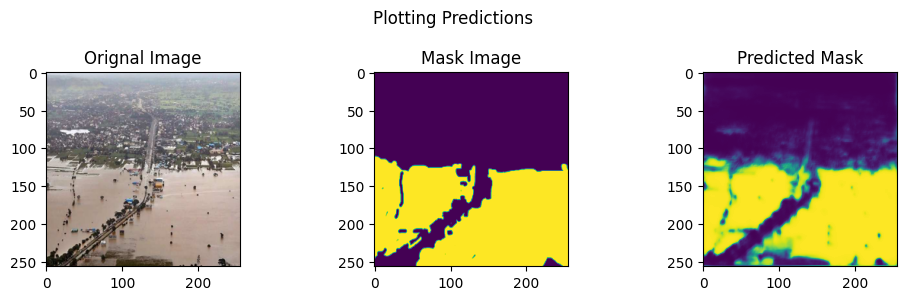

In [28]:
for i in range(7):
    y_pred = u2net_model.predict(np.reshape(X_test_images[i],(1,CFG.imageSize,CFG.imageSize,3)))
    plot(X_test_images[i],y_test_images[i],y_pred[0])

## Thank You